In [31]:
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup # python3 pip install bs4
import nltk
nltk.download('vader_lexicon')# python3 -m pip install nltk In the console, you can also just nltk.download() => select the wanted package in the GUI

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/temp/nltk_data...


True

In [36]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt

<table border="0" cellpadding="1" cellspacing="0" class="fullview-news-outer" id="news-table" width="100%">
<tr><td align="right" style="white-space:nowrap" width="130">Sep-28-20 02:51PM  </td><td align="left"><div class="news-link-container"><div class="news-link-left"><a class="tab-link-news" href="https://finance.yahoo.com/news/stock-market-news-live-september-28-2020-113411585.html" target="_blank">Stock market news live updates: Stocks jump, Dow gains 500+ points</a></div><div class="news-link-right"><span style="color:#aa6dc0;font-size:9px"> Yahoo Finance</span></div></div></td></tr>
<tr><td align="right" width="130">02:46PM  </td><td align="left"><div class="news-link-container"><div class="news-link-left"><a class="tab-link-news" href="https://www.fool.com/investing/2020/09/28/snowflake-homebuilders-money-girl-and-more/?source=eptyholnk0000202&amp;utm_source=yahoo-host&amp;utm_medium=feed&amp;utm_campaign=article" target="_blank">Snowflake, Homebuilders, Money Girl, and More</a

<Figure size 720x576 with 0 Axes>

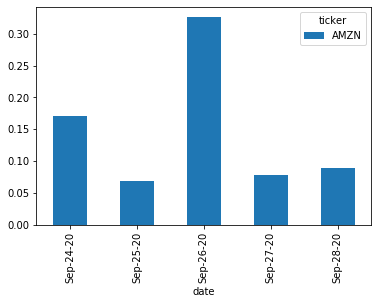

In [58]:
# Parsing the url
# tsx :  https://money.tmx.com/en/quote/TICKER/news
# NYSE : https://finviz.com/quote.ashx?t=
finviz_url = 'https://finviz.com/quote.ashx?t='
tickers = ['AMZN', 'AAPL', 'FB']

news_tables = {}

for ticker in tickers:
    url = finviz_url + ticker
    
    req = Request(url=url, headers={'user-agent': 'my-app'})
    response = urlopen(req)

    html = BeautifulSoup(response, 'html')
    
    news_table = html.find(id='news-table')
    print(news_table)
    news_tables[ticker] = news_table
    break
amzn_data = news_tables['AMZN']
amzn_rows = amzn_data.findAll('tr')
parsed_data = []
for ticker, news_table in news_tables.items():
    for row in news_table.findAll('tr'):
        title = row.a.get_text()
        date_data = row.td.text.split(' ')
        
        if len(date_data) == 1:
            time = date_data[0] # hour
        else:
            date = date_data[0] # month/year
            time = date_data[1]
            
        parsed_data.append([ticker, date, time, title])
df = pd.DataFrame(parsed_data, columns=['ticker', 'date', 'time', 'title'])

vader = SentimentIntensityAnalyzer()
f = lambda title: vader.polarity_scores(title)['compound']
df['compound'] = df['title'].apply(f)
df['dates'] = pd.to_datetime(df.date).dt.date # convert our date column and modify it from string to date format

plt.figure(figsize=(10,8))

mean_df = df.groupby(['ticker', 'date']).mean()
mean_df = mean_df.unstack()
mean_df = mean_df.xs('compound', axis="columns").transpose() # xs enables us to remove the unwanted compound column
#print(mean_df)
mean_df.plot(kind='bar')
plt.show()

<Figure size 720x360 with 0 Axes>

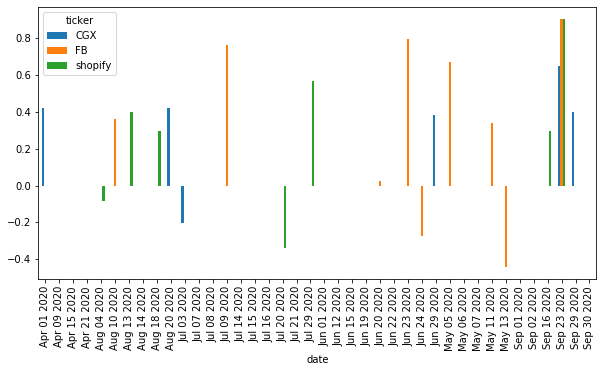

In [317]:
# same as above, but from TSX website
finviz_url = 'https://www.newswire.ca/search/news/?keyword='
tickers = ['shopify','CGX', 'FB']
#full_ticker_name{'CGX':'Cineplex','AAPL':'APPLE', 'FB':'Facebook'}

news_tables = {}

for ticker in tickers:
    url = finviz_url + ticker
    #print(url)
    req = Request(url=url, headers={'user-agent': 'my-app'})
    response = urlopen(req)
    html = BeautifulSoup(response, 'html')
    news_table = html.find(id='main').find("section", class_="container search-results-text")
    news_tables[ticker] = news_table
    

# Sentiment of title analysis
parsed_data = []
parsed_data_articles = {}
for ticker, news_table in news_tables.items():
    print("="*100)
    for row in news_table.findAll("div", class_="col-sm-8 col-lg-9 pull-left card"):
        title = row.h3.a.get_text()
        date_data = (row.h3.small.text).replace(' ET','')
        time = date_data.split(',')[2]
        date = date_data.split(',')[0]+date_data.split(',')[1]
        #parsed_data.append([ticker, date, time, title])
        
        # Whole article sentiment
        article_url = row.h3.a['href']
        article_url = 'https://www.newswire.ca'+article_url
        req = Request(url=article_url, headers={'user-agent': 'my-app'})
        response = urlopen(req)
        html = BeautifulSoup(response, 'html')
        try:
            full_news_article = html.find(id='main').find("article", class_="news-release carousel-template").findAll('p')
            full_text = []
            for text in full_news_article:

                if text.get_text() is not None:
                    try: 
                        text.b.text.startswith('About ')
                        break
                    except:
                        paragraph = text.get_text()
                        full_text.append(paragraph)
        except: pass

                
                
                
        #print("FULL TEXT : ", full_text)
        full_text=' '.join(full_text)
        parsed_data.append([ticker, date, time, title, full_text])
        





df = pd.DataFrame(parsed_data, columns=['ticker', 'date','time', 'title', 'full_text'])
vader = SentimentIntensityAnalyzer()
f = lambda full_text: vader.polarity_scores(full_text)['compound']
#df['compound'] = df['title'].apply(f)
df['compound'] = df['full_text'].apply(f) #compound on full text
df['compound'] = df['title'].apply(f)
df['dates'] = pd.to_datetime(df.date).dt.date # convert our date column and modify it from string to date format

plt.figure(figsize=(10,5))

mean_df = df.groupby(['ticker', 'date']).mean()
mean_df = mean_df.unstack()
mean_df = mean_df.xs('compound', axis="columns").transpose() # xs enables us to remove the unwanted compound column
#print(mean_df)
mean_df.plot(kind='bar')
plt.show()

In [280]:
full_news_article[4].b.get_text()

AttributeError: 'NoneType' object has no attribute 'get_text'

In [291]:
html.find(id='main')

<main id="main" role="main">
<script src="/etc.clientlibs/prncom/clientlibs/share_clientlibs.min.js" type="text/javascript"></script>
<article class="news-release static-gallery-template">
<header class="container release-header">
<div class="row">
<div class="col-sm-7 col-sm-offset-1 col-vcenter col-xs-12">
<h1>Vegaste Technologies Corp. Announces Name Change to PlantX Life Inc.
</h1>
</div>
<div class="col-sm-3 col-xs-12 col-vcenter">
<img alt="PlantX Life Inc - Name Change (CNW Group/PlantX Life Inc.)" class="img-responsive logo logo-wrapper" data-asset-label="Logo" data-asset-type="photo" data-download-url="https://mma.prnewswire.com/media/1283202/PlantX_Life_Inc__Vegaste_Technologies_Corp__Announces_Name_Chang.jpg?p=publish" data-facebook-share-text="PlantX Life Inc - Name Change (CNW Group/PlantX Life Inc.)" data-facebook-share-url="https://mma.prnewswire.com/media/1283202/PlantX_Life_Inc__Vegaste_Technologies_Corp__Announces_Name_Chang.jpg?p=facebook" data-linkedin-share-url="ht

<Figure size 7200x576 with 0 Axes>

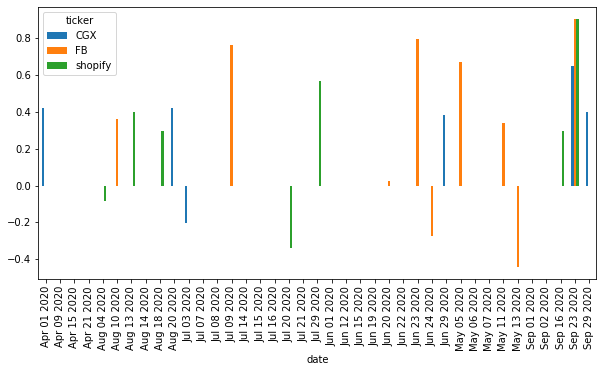

In [316]:
plt.figure(figsize=(100,8))
plt.rcParams['figure.figsize'] = [10, 5]
mean_df.plot(kind='bar')
plt.show()